Resultados de backtesting:
BuyHold: -6.32%
SMA_Crossover: 6.45%
MACD: 6.45%
RSI: 0.00%

Recomendación: HOLD: No hay señal clara.


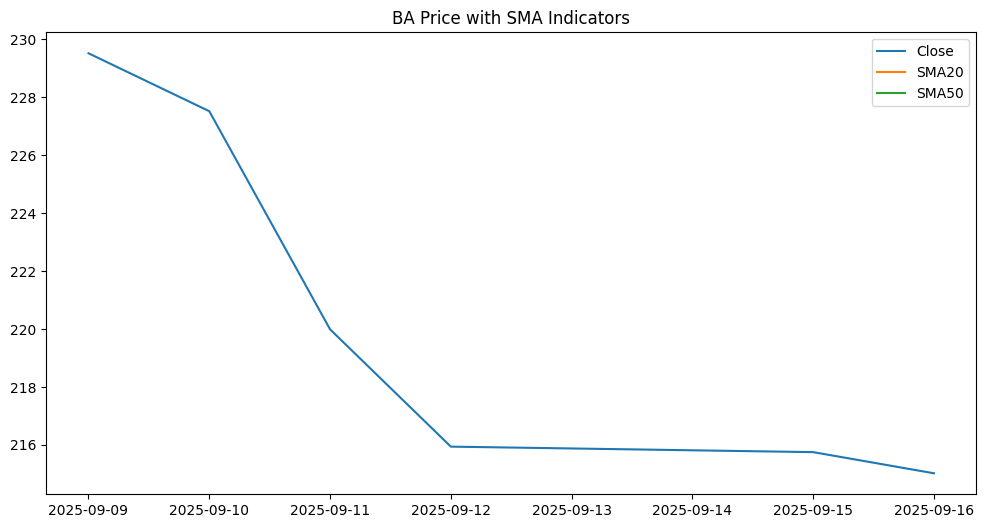

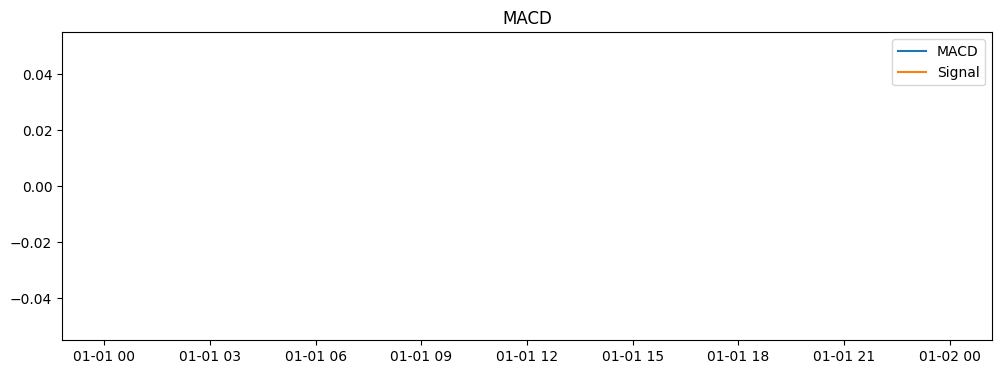

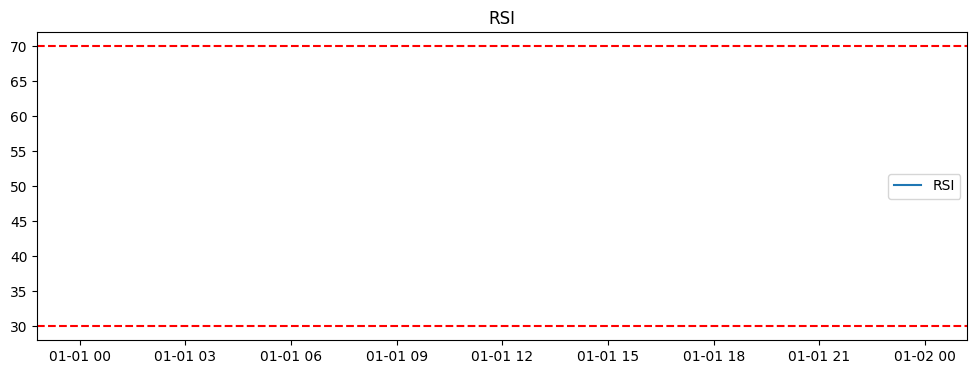

In [10]:
import lseg.data as ld
from lseg.data.content import historical_pricing as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

# Abrir sesión
ld.open_session()

# Función para obtener datos desde Refinitiv
def fetch_refinitiv(ticker="BA.N", start="2025-09-08", end="2025-09-16"):
    definition = hp.summaries.Definition(
    universe=["BA.N"],
    interval="P1D",  # 1 día
    start="2025-09-08",
    end="2025-09-16"
    )
    response = definition.get_data()

    # El dataframe real está en response.data.df
    df = response.data.df

    # Dependiendo del entorno, las columnas pueden variar.
    # Normalizamos con alias típicos.
    mapping = {
        "OPEN_PRC": "open",
        "HIGH_1": "high",
        "LOW_1": "low",
        "TRDPRC_1": "close",
        "ACVOL_1": "volume"
    }
    for old, new in mapping.items():
        if old in df.columns:
            df = df.rename(columns={old: new})

    # Nos aseguramos de tener las columnas estándar
    for col in ["open", "high", "low", "close", "volume"]:
        if col not in df.columns:
            df[col] = np.nan

    return df[["open", "high", "low", "close", "volume"]]

# Calcular indicadores técnicos
def add_indicators(df):
    df["SMA20"] = ta.trend.sma_indicator(df["close"], window=20)
    df["SMA50"] = ta.trend.sma_indicator(df["close"], window=50)
    df["RSI"] = ta.momentum.rsi(df["close"], window=14)
    macd = ta.trend.MACD(df["close"])
    df["MACD"] = macd.macd()
    df["MACD_signal"] = macd.macd_signal()
    return df

# Backtesting simple
def backtest_strategies(df):
    results = {}

    # Estrategia Buy & Hold
    buy_price = df["close"].iloc[0]
    sell_price = df["close"].iloc[-1]
    results["BuyHold"] = (sell_price - buy_price) / buy_price * 100

    # Estrategia SMA Crossover
    df["Signal"] = np.where(df["SMA20"] > df["SMA50"], 1, -1)
    df["Strategy"] = df["Signal"].shift(1) * df["close"].pct_change()
    results["SMA_Crossover"] = df["Strategy"].cumsum().iloc[-1] * 100

    # Estrategia MACD
    df["MACD_signal_trade"] = np.where(df["MACD"] > df["MACD_signal"], 1, -1)
    df["MACD_strategy"] = df["MACD_signal_trade"].shift(1) * df["close"].pct_change()
    results["MACD"] = df["MACD_strategy"].cumsum().iloc[-1] * 100

    # Estrategia RSI
    df["RSI_signal"] = np.where(df["RSI"] < 30, 1, np.where(df["RSI"] > 70, -1, 0))
    df["RSI_strategy"] = df["RSI_signal"].shift(1) * df["close"].pct_change()
    results["RSI"] = df["RSI_strategy"].cumsum().iloc[-1] * 100

    return results

# Graficar
def plot_results(df, ticker="BA"):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["close"], label="Close")
    plt.plot(df.index, df["SMA20"], label="SMA20")
    plt.plot(df.index, df["SMA50"], label="SMA50")
    plt.title(f"{ticker} Price with SMA Indicators")
    plt.legend()
    plt.savefig("price_sma.png")

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["MACD"], label="MACD")
    plt.plot(df.index, df["MACD_signal"], label="Signal")
    plt.title("MACD")
    plt.legend()
    plt.savefig("macd.png")

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["RSI"], label="RSI")
    plt.axhline(30, color='red', linestyle='--')
    plt.axhline(70, color='red', linestyle='--')
    plt.title("RSI")
    plt.legend()
    plt.savefig("rsi.png")

# Recomendación final
def recommendation(results):
    avg_return = np.mean(list(results.values()))
    if avg_return > 2:
        return "BUY: Estrategias muestran retorno positivo."
    elif avg_return < -2:
        return "SELL: Estrategias muestran retorno negativo."
    else:
        return "HOLD: No hay señal clara."

# Ejecución principal
def main():
    df = fetch_refinitiv("BA.N", "2025-09-08", "2025-09-16")
    df = add_indicators(df)
    results = backtest_strategies(df)
    plot_results(df, "BA")

    print("Resultados de backtesting:")
    for strat, ret in results.items():
        print(f"{strat}: {ret:.2f}%")

    print("\nRecomendación:", recommendation(results))

if __name__ == "__main__":
    main()

Resultados de backtesting:
BuyHold: -6.32%
SMA_Crossover: 6.45%
MACD: 6.45%
RSI: 0.00%

Recomendación: HOLD: No hay señal clara.


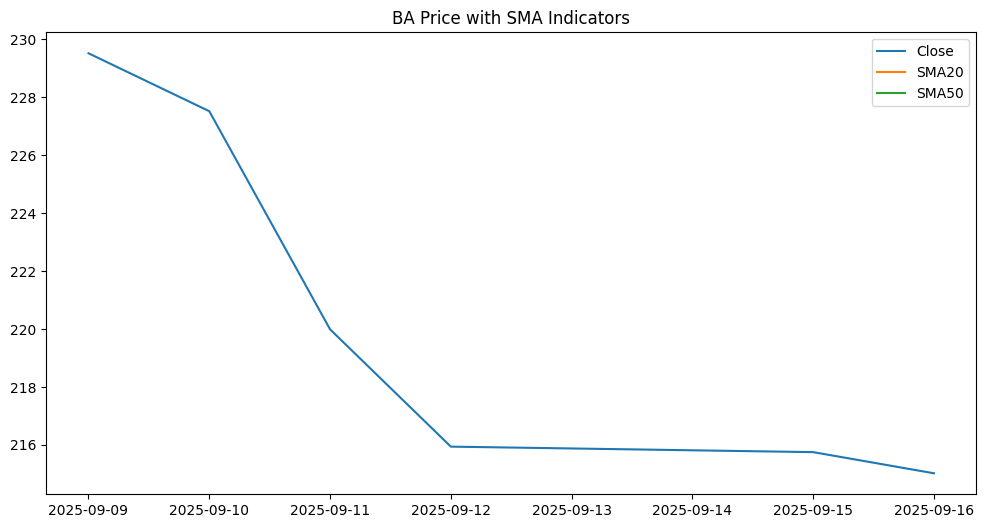

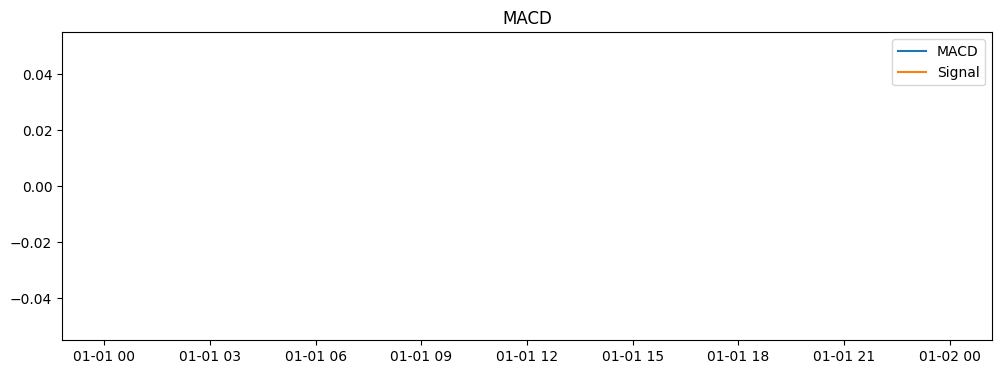

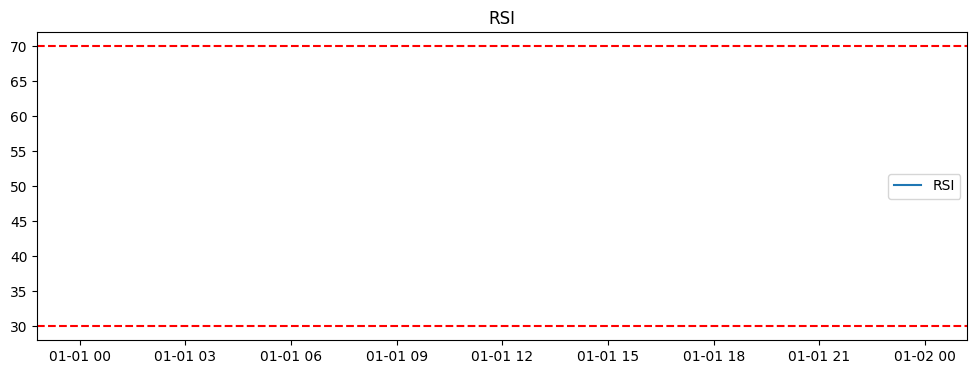

In [11]:
import lseg.data as ld
from lseg.data.content import historical_pricing as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

# Abrir sesión
ld.open_session()

# Función para obtener datos desde Refinitiv
def fetch_refinitiv(ticker="BA", start="2025-09-08", end="2025-09-16"):
    definition = hp.summaries.Definition(
        universe=[ticker],
        interval="P1D",  # Velas diarias
        start=start,
        end=end
    )
    response = definition.get_data()
    df = response.data.df

    # Normalizar nombres de columnas
    mapping = {
        "OPEN_PRC": "open",
        "HIGH_1": "high",
        "LOW_1": "low",
        "TRDPRC_1": "close",
        "ACVOL_1": "volume"
    }
    for old, new in mapping.items():
        if old in df.columns:
            df = df.rename(columns={old: new})

    for col in ["open", "high", "low", "close", "volume"]:
        if col not in df.columns:
            df[col] = np.nan

    df.index = pd.to_datetime(df.index)
    return df[["open", "high", "low", "close", "volume"]]

# Calcular indicadores técnicos
def add_indicators(df):
    df['SMA20'] = ta.trend.SMAIndicator(df['close'], window=20).sma_indicator()
    df['SMA50'] = ta.trend.SMAIndicator(df['close'], window=50).sma_indicator()
    df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    macd = ta.trend.MACD(df['close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    return df

# Backtesting simple
def backtest_strategies(df):
    results = {}

    # Estrategia Buy & Hold
    buy_price = df['close'].iloc[0]
    sell_price = df['close'].iloc[-1]
    results['BuyHold'] = (sell_price - buy_price) / buy_price * 100

    # Estrategia SMA Crossover
    df['Signal'] = np.where(df['SMA20'] > df['SMA50'], 1, -1)
    df['Strategy'] = df['Signal'].shift(1) * df['close'].pct_change()
    results['SMA_Crossover'] = df['Strategy'].cumsum().iloc[-1] * 100

    # Estrategia MACD
    df['MACD_signal_trade'] = np.where(df['MACD'] > df['MACD_signal'], 1, -1)
    df['MACD_strategy'] = df['MACD_signal_trade'].shift(1) * df['close'].pct_change()
    results['MACD'] = df['MACD_strategy'].cumsum().iloc[-1] * 100

    # Estrategia RSI
    df['RSI_signal'] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0))
    df['RSI_strategy'] = df['RSI_signal'].shift(1) * df['close'].pct_change()
    results['RSI'] = df['RSI_strategy'].cumsum().iloc[-1] * 100

    return results

# Graficar
def plot_results(df, ticker='BA'):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['close'], label='Close')
    plt.plot(df.index, df['SMA20'], label='SMA20')
    plt.plot(df.index, df['SMA50'], label='SMA50')
    plt.title(f'{ticker} Price with SMA Indicators')
    plt.legend()
    plt.savefig('price_sma.png')

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df['MACD'], label='MACD')
    plt.plot(df.index, df['MACD_signal'], label='Signal')
    plt.title('MACD')
    plt.legend()
    plt.savefig('macd.png')

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df['RSI'], label='RSI')
    plt.axhline(30, color='red', linestyle='--')
    plt.axhline(70, color='red', linestyle='--')
    plt.title('RSI')
    plt.legend()
    plt.savefig('rsi.png')

# Recomendación final
def recommendation(results):
    avg_return = np.mean(list(results.values()))
    if avg_return > 2:
        return 'BUY: Estrategias muestran retorno positivo.'
    elif avg_return < -2:
        return 'SELL: Estrategias muestran retorno negativo.'
    else:
        return 'HOLD: No hay señal clara.'

# Ejecución principal
def main():
    df = fetch_refinitiv('BA.N', '2025-09-08', '2025-09-16')
    df = add_indicators(df)
    results = backtest_strategies(df)
    plot_results(df, 'BA')

    print('Resultados de backtesting:')
    for strat, ret in results.items():
        print(f'{strat}: {ret:.2f}%')

    print('\nRecomendación:', recommendation(results))

if __name__ == '__main__':
    main()

In [12]:
# Backtester completo para BA (simulación escolar). No requiere 'ta' externa.
import math
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lseg.data as ld
import warnings
warnings.filterwarnings('ignore')

ld.open_session()  # abre sesión en Refinitiv - asegúrate de tener credenciales configuradas

def fetch_ba(start='2025-09-08', end='2025-09-16', ticker='BA'):
    # Intentar distintos endpoints/paths según la versión del SDK
    try:
        # intento simple: get_history (si existe en tu versión)
        if hasattr(ld, 'get_history'):
            df = ld.get_history([ticker], fields=['TR.PriceClose','TR.Volume','TR.PriceOpen','TR.PriceHigh','TR.PriceLow'], start=start, end=end, interval='1D')
            # normalizar nombres si vienen como columnas amigables
            if 'Price Close' in df.columns:
                df = df.rename(columns={'Price Close':'close','Price Open':'open','Price High':'high','Price Low':'low','Volume':'volume','TR.PriceClose':'close'})
        else:
            # fallback a content/historical_pricing si disponible
            from lseg.data.content import historical_pricing as hp
            definition = hp.summaries.Definition(universe=[ticker], interval='P1D', start=start, end=end)
            response = definition.get_data()
            df = response.data.df
            mapping = {'OPEN_PRC':'open','HIGH_1':'high','LOW_1':'low','TRDPRC_1':'close','ACVOL_1':'volume'}
            for old,new in mapping.items():
                if old in df.columns: df = df.rename(columns={old:new})
        # Asegurar columnas estándar
        for col in ['open','high','low','close','volume']:
            if col not in df.columns:
                df[col] = np.nan
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        return df[['open','high','low','close','volume']]
    except Exception as e:
        raise RuntimeError('Error fetching data from Refinitiv: ' + str(e))

# Indicadores sin librerías externas
def SMA(s, n): return s.rolling(n, min_periods=1).mean()
def EMA(s, n): return s.ewm(span=n, adjust=False).mean()
def MACD(series, a=12, b=26, c=9):
    ema_a = EMA(series, a)
    ema_b = EMA(series, b)
    macd = ema_a - ema_b
    signal = EMA(macd, c)
    hist = macd - signal
    return macd, signal, hist
def RSI(series, n=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(n, min_periods=1).mean()
    ma_down = down.rolling(n, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))
def bollinger(series, n=20, k=2):
    m = SMA(series, n)
    s = series.rolling(n, min_periods=1).std()
    return m + k*s, m, m - k*s
def ATR(df, n=14):
    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - df['close'].shift()).abs()
    tr3 = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(n, min_periods=1).mean()
def OBV(df):
    direction = np.sign(df['close'].diff()).fillna(0)
    return (direction * df['volume']).cumsum()

# Métricas financieras
def performance_metrics(returns):
    # returns: serie de retornos simples (pct_change)
    cumul = (1 + returns).cumprod()
    total_return = cumul.iloc[-1] - 1
    days = (returns.index[-1] - returns.index[0]).days or 1
    annual = (1 + total_return) ** (365.0 / max(days,1)) - 1
    vol = returns.std() * math.sqrt(252)
    sharpe = (annual - 0.0) / vol if vol>0 else np.nan
    dd = (cumul / cumul.cummax() - 1).min()
    return {'total_return': total_return, 'annualized': annual, 'volatility':vol, 'sharpe':sharpe, 'max_drawdown': dd}

# Simular varias estrategias cortas
def simulate_strategies(df, entry_date='2025-09-08'):
    df = df.copy()
    df['return'] = df['close'].pct_change().fillna(0)
    # indicadores
    df['sma20'] = SMA(df['close'], 20)
    df['sma50'] = SMA(df['close'], 50)
    df['ema12'] = EMA(df['close'], 12)
    df['ema26'] = EMA(df['close'], 26)
    df['macd'], df['macd_signal'], df['macd_hist'] = MACD(df['close'])
    df['rsi14'] = RSI(df['close'], 14)
    df['bb_up'], df['bb_mid'], df['bb_low'] = bollinger(df['close'], 20, 2)
    df['atr14'] = ATR(df, 14)
    df['obv'] = OBV(df)


    # Buy & Hold (from entry to last)
    entry = pd.to_datetime(entry_date)
    if entry not in df.index:
        # if exact date missing, choose next available date
        possible = df.loc[df.index >= entry]
        if possible.empty:
            raise RuntimeError('No data at or after entry_date')
        entry = possible.index[0]
    buy_price = df.at[entry, 'close']
    last_price = df['close'].iloc[-1]
    bh_ret = last_price / buy_price - 1

    # SMA crossover strategy (long when sma20 > sma50)
    df['pos_sma'] = (df['sma20'] > df['sma50']).astype(int)
    df['strat_sma'] = df['pos_sma'].shift(1) * df['return']
    sma_perf = performance_metrics(df['strat_sma'])

    # MACD strategy (long when macd>signal)
    df['pos_macd'] = (df['macd'] > df['macd_signal']).astype(int)
    df['strat_macd'] = df['pos_macd'].shift(1) * df['return']
    macd_perf = performance_metrics(df['strat_macd'])

    # RSI mean reversion (buy when rsi<30, sell when rsi>70)
    df['pos_rsi'] = 0
    df.loc[df['rsi14'] < 30, 'pos_rsi'] = 1
    df.loc[df['rsi14'] > 70, 'pos_rsi'] = 0
    df['pos_rsi'] = df['pos_rsi'].ffill().fillna(0)
    df['strat_rsi'] = df['pos_rsi'].shift(1) * df['return']
    rsi_perf = performance_metrics(df['strat_rsi'])

    # Bollinger breakout (long when price crosses above upper band, short when below lower)
    df['pos_bb'] = 0
    df.loc[df['close'] > df['bb_up'], 'pos_bb'] = -1
    df.loc[df['close'] < df['bb_low'], 'pos_bb'] = 1
    df['pos_bb'] = df['pos_bb'].ffill().fillna(0)
    df['strat_bb'] = df['pos_bb'].shift(1) * df['return']
    bb_perf = performance_metrics(df['strat_bb'])

    # Buy & Hold perf metrics (from entry to last)
    bh_series = df.loc[entry:]['close'].pct_change().fillna(0)
    bh_perf_metrics = performance_metrics(bh_series)

    results = {
        'entry_date': entry,
        'buy_price': buy_price,
        'last_price': last_price,
        'bh_return': bh_ret,
        'bh_metrics': bh_perf_metrics,
        'sma_perf': sma_perf,
        'macd_perf': macd_perf,
        'rsi_perf': rsi_perf,
        'bb_perf': bb_perf,
        'df': df
    }
    return results

# Helper: drawdown and robust recommendation
import pandas as pd
import numpy as np

def calc_drawdown(returns):
    """Calcula la serie de drawdown para una serie de retornos (simples).
    Devuelve la serie de drawdown (fracciones negativas) para poder sacar min/max.
    Si hay error, devuelve una serie de ceros con el mismo índice.
    """
    try:
        cumul = (1 + returns.fillna(0)).cumprod()
        drawdown = cumul / cumul.cummax() - 1
        return drawdown
    except Exception:
        try:
            return pd.Series(index=returns.index, data=0.0)
        except Exception:
            return pd.Series()


def make_recommendation(results):
    """Heuristic aggregation based on strategy performance and latest signals.

    Returns:
        (rec (str), score (float))

    The function is defensive: checks presence of columns and metrics before
    adding points to avoid exceptions when data is incomplete.
    """
    df = results.get('df') if isinstance(results, dict) else None
    if df is None or getattr(df, 'shape', (0,))[0] == 0:
        return ('HOLD (no hay datos)', 0.0)

    last = df.iloc[-1]
    score = 0.0

    # MA consensus
    try:
        if last.get('sma20', 0) > last.get('sma50', 0):
            score += 1.0
        else:
            score -= 1.0
    except Exception:
        pass

    # MACD
    try:
        if last.get('macd', 0) > last.get('macd_signal', 0):
            score += 1.0
        else:
            score -= 1.0
    except Exception:
        pass

    # RSI
    try:
        rsi_val = last.get('rsi14', None)
        if rsi_val is not None:
            if rsi_val < 30:
                score += 1.0
            elif rsi_val > 70:
                score -= 1.0
    except Exception:
        pass

    # Price vs Bollinger
    try:
        if last.get('close', 0) < last.get('bb_low', float('inf')):
            score += 0.5
        elif last.get('close', 0) > last.get('bb_up', float('-inf')):
            score -= 0.5
    except Exception:
        pass

    # OBV trend (compare last vs 5 bars ago)
    try:
        if 'obv' in df.columns and df['obv'].shape[0] >= 5:
            if df['obv'].iloc[-1] > df['obv'].iloc[-5]:
                score += 0.5
            else:
                score -= 0.5
    except Exception:
        pass

    # Strategy performances (prefer positive total_return and sharpe > 0.3)
    strat_scores = 0.0
    for k in ('sma_perf', 'macd_perf', 'rsi_perf', 'bb_perf'):
        perf = results.get(k, {}) if isinstance(results, dict) else {}
        try:
            if perf.get('total_return', 0) > 0:
                strat_scores += 1.0
        except Exception:
            pass
        try:
            sharpe_val = perf.get('sharpe')
            if sharpe_val is not None and not np.isnan(sharpe_val) and sharpe_val > 0.3:
                strat_scores += 0.5
        except Exception:
            pass
    score += strat_scores

    # Final rule thresholds
    if score >= 3.0:
        rec = 'BUY or HOLD (Bullish consensus and strategies positive)'
    elif score >= 1.0:
        rec = 'HOLD (Mixed but not bearish)'
    else:
        rec = 'SELL (Bearish consensus)'

    return rec, score

# Runner convenience function
def run_ba_backtest(entry_date='2025-09-08', start='2025-09-08', end='2025-09-16', ticker='BA'):
    df = fetch_ba(start=start, end=end, ticker=ticker)
    results = simulate_strategies(df, entry_date=entry_date)
    rec, score = make_recommendation(results)
    print('Entry date:', results['entry_date'].date())
    print('Buy price:', results['buy_price'])
    print('Last price:', results['last_price'])
    print(f"Buy & Hold return: {results['bh_return']*100:.2f}%")
    print('--- Strategy Performance ---')
    for k in ('sma_perf','macd_perf','rsi_perf','bb_perf'):
        p = results[k]
        print(f"{k}: total {p['total_return']*100:.2f}%, annualized {p['annualized']*100:.2f}%, vol {p['volatility']:.2%}, sharpe {p['sharpe']:.2f}, maxdd {p['max_drawdown']:.2%}")
    print('--- Overall Recommendation ---')
    print(rec)
    return results, rec, score
    
# Example run (uncomment to execute)
results, rec, score = run_ba_backtest(entry_date='2025-09-08', start='2025-09-08', end='2025-09-16', ticker='BA')

Entry date: 2025-09-08
Buy price: 230.95
Last price: 215.02
Buy & Hold return: -6.90%
--- Strategy Performance ---
sma_perf: total 0.00%, annualized 0.00%, vol 0.00%, sharpe nan, maxdd 0.00%
macd_perf: total 0.00%, annualized 0.00%, vol 0.00%, sharpe nan, maxdd 0.00%
rsi_perf: total -6.32%, annualized -94.91%, vol 20.45%, sharpe -4.64, maxdd -6.32%
bb_perf: total 0.00%, annualized 0.00%, vol 0.00%, sharpe nan, maxdd 0.00%
--- Overall Recommendation ---
SELL (Bearish consensus)


In [13]:
# Análisis extendido: 6 meses + comisiones, trade logs y pruebas de sensibilidad
import itertools

def generate_trade_log_from_positions(df, pos_col='pos_sma', price_col='close', commission=0.0, slippage=0.0):
    # Simple trade logger: registra entradas/salidas cuando cambia la posición (0/1/-1)
    trades = []
    current_pos = 0
    entry_price = None
    entry_date = None
    for idx, row in df.iterrows():
        pos = row[pos_col]
        price = row[price_col]
        if pos != current_pos:
            # close existing
            if current_pos != 0 and entry_price is not None:
                exit_price = price * (1 - slippage if current_pos>0 else 1 + slippage)
                pnl = (exit_price - entry_price) * current_pos - commission
                trades.append({'entry_date': entry_date, 'exit_date': idx, 'entry_price': entry_price, 'exit_price': exit_price, 'position': current_pos, 'pnl': pnl})
                entry_price = None
                entry_date = None
            # open new if pos != 0
            if pos != 0:
                entry_price = price * (1 + slippage if pos>0 else 1 - slippage)
                entry_date = idx
            current_pos = pos
    # If still open at the end, close
    if current_pos != 0 and entry_price is not None:
        price = df[price_col].iloc[-1]
        exit_price = price * (1 - slippage if current_pos>0 else 1 + slippage)
        pnl = (exit_price - entry_price) * current_pos - commission
        trades.append({'entry_date': entry_date, 'exit_date': df.index[-1], 'entry_price': entry_price, 'exit_price': exit_price, 'position': current_pos, 'pnl': pnl})
    return pd.DataFrame(trades)

def run_extended_backtest(entry_date='2025-09-08', months=6, ticker='BA', commission=0.0, slippage=0.0):
    # calcular fechas
    start_dt = (pd.to_datetime(entry_date) - pd.DateOffset(months=months)).strftime('%Y-%m-%d')
    end_dt = pd.to_datetime('2025-09-16').strftime('%Y-%m-%d')
    print(f'Running extended backtest for {ticker} from {start_dt} to {end_dt} (entry at {entry_date})')
    df = fetch_ba(start=start_dt, end=end_dt, ticker=ticker)
    results = simulate_strategies(df, entry_date=entry_date)
    # Generate trade logs for each strategy positions recorded in results['df']
    df2 = results['df']
    trade_logs = {}
    for pos_col in ['pos_sma','pos_macd','pos_rsi','pos_bb']:
        if pos_col in df2.columns:
            trade_logs[pos_col] = generate_trade_log_from_positions(df2, pos_col=pos_col, commission=commission, slippage=slippage)
        else:
            trade_logs[pos_col] = pd.DataFrame()

    # Resumir resultados
    summary = {}
    for k in ['sma','macd','rsi','bb']:  # estrategias
        if f'pos_{k}' in df2:
            # rendimiento total desde la entrada
            df2[f'ret_{k}'] = df2[f'pos_{k}'] * df2['return']
            total_return = df2[f'ret_{k}'].sum()
            summary[f'{k}_total_return'] = total_return
            # rendimiento anualizado
            days_held = (df2.index[-1] - df2[df2[f'pos_{k}'] != 0].index[0]).days
            annualized_return = (1 + total_return) ** (365.0 / max(days_held,1)) - 1
            summary[f'{k}_annualized_return'] = annualized_return
            # máximo drawdown
            drawdown = calc_drawdown(df2[f'ret_{k}'])
            max_drawdown = drawdown.min()
            summary[f'{k}_max_drawdown'] = max_drawdown
    
    # Agregar resultados al diccionario de resultados
    results['trade_logs'] = trade_logs
    results['summary'] = summary
    return results

# Ejemplo de ejecución del backtest extendido
extended_results = run_extended_backtest(entry_date='2025-09-08', months=6, ticker='BA', commission=0.0, slippage=0.0)

# Mostrar resumen de resultados
print('--- Resumen de Resultados ---')
for k, v in extended_results['summary'].items():
    print(f'{k}: {v:.2%}')

# Mostrar recomendaciones prácticas
print('\n--- Recomendaciones Prácticas ---')
rec, score = make_recommendation(extended_results)
print(rec)
print(f'Score: {score:.2f}')

Running extended backtest for BA from 2025-03-08 to 2025-09-16 (entry at 2025-09-08)
--- Resumen de Resultados ---
sma_total_return: 34.68%
sma_annualized_return: 95.59%
sma_max_drawdown: -9.12%
macd_total_return: 50.20%
macd_annualized_return: 119.38%
macd_max_drawdown: -6.59%
rsi_total_return: 0.04%
rsi_annualized_return: 0.10%
rsi_max_drawdown: -0.34%
bb_total_return: -19.95%
bb_annualized_return: -38.87%
bb_max_drawdown: -18.65%

--- Recomendaciones Prácticas ---
BUY or HOLD (Bullish consensus and strategies positive)
Score: 4.50
--- Resumen de Resultados ---
sma_total_return: 34.68%
sma_annualized_return: 95.59%
sma_max_drawdown: -9.12%
macd_total_return: 50.20%
macd_annualized_return: 119.38%
macd_max_drawdown: -6.59%
rsi_total_return: 0.04%
rsi_annualized_return: 0.10%
rsi_max_drawdown: -0.34%
bb_total_return: -19.95%
bb_annualized_return: -38.87%
bb_max_drawdown: -18.65%

--- Recomendaciones Prácticas ---
BUY or HOLD (Bullish consensus and strategies positive)
Score: 4.50


In [14]:
# Recomendación adaptada a horizonte corto (vender antes de diciembre 2025)
import pandas as pd

def make_horizon_recommendation(results, project_end='2025-12-31', min_target_pct=0.02, max_days=None):
    """Devuelve recomendación (BUY/HOLD/SELL) considerando horizonte del proyecto.
    results: dict retornado por simulate_strategies/run_ba_backtest
    project_end: fecha final del proyecto (inclusive)
    min_target_pct: objetivo mínimo de ganancia absoluta para recomendar BUY (ej. 2% en horizonte)
    max_days: si se pasa, limitar resultados a ventanas <= max_days
    """
    df = results['df']
    # Period desde entry a project_end (o último disponible si antes)
    entry = results['entry_date']
    pe = pd.to_datetime(project_end)
    if pe > df.index[-1]:
        pe = df.index[-1]
    sub = df.loc[entry:pe]
    if sub.empty:
        return 'HOLD (no hay datos suficientes para el horizonte del proyecto)'
    # Calcular Buy & Hold en el horizonte
    buy = results['buy_price']
    end_price = sub['close'].iloc[-1]
    ph_return = end_price / buy - 1
    days = (sub.index[-1] - entry).days or 1
    # Métrica de seguridad: si ph_return > min_target_pct y vol baja => BUY, sino SELL/HOLD
    vol = sub['close'].pct_change().std() * (252**0.5)
    # criterio conservador para horizonte corto:
    # - si pérdida esperada (ph_return) negativa -> SELL
    # - si ganancia pequeña (< min_target_pct) -> HOLD
    # - si ganancia >= min_target_pct y sharpe estimado > 0.3 -> BUY
    # sharpe estimado simple usando daily mean*252 / vol
    daily_mean = sub['close'].pct_change().mean() or 0.0
    annual_est = (1 + daily_mean) ** 252 - 1
    sharpe_est = annual_est / (vol if vol>0 else 1e-9)
    if ph_return < 0:
        rec = f'SELL (Pérdida esperada {ph_return*100:.2f}% en horizonte hasta {pe.date()})'
    elif ph_return < min_target_pct:
        rec = f'HOLD (Ganancia {ph_return*100:.2f}% < objetivo {min_target_pct*100:.1f}% para horizonte)'
    else:
        if sharpe_est > 0.3:
            rec = f'BUY (Ganancia {ph_return*100:.2f}% y sharpe estimado {sharpe_est:.2f})'
        else:
            rec = f'HOLD (Ganancia {ph_return*100:.2f}% pero sharpe débil {sharpe_est:.2f})'
    return rec

def run_project_backtest(entry_date='2025-09-08', project_end='2025-12-31', months_history=6, ticker='BA', commission=0.0, slippage=0.0, min_target_pct=0.02):
    # Ejecuta análisis extendido y devuelve recomendación para horizonte de proyecto
    start_hist = (pd.to_datetime(entry_date) - pd.DateOffset(months=months_history)).strftime('%Y-%m-%d')
    end_hist = pd.to_datetime(project_end).strftime('%Y-%m-%d')
    print(f'Fetching {ticker} from {start_hist} to {end_hist} (entry {entry_date})')
    df = fetch_ba(start=start_hist, end=end_hist, ticker=ticker)
    results = simulate_strategies(df, entry_date=entry_date)
    # apply commission/slippage to trade logs
    # generate trade logs for each pos column
    df2 = results['df']
    logs = {}
    for pos_col in ['pos_sma','pos_macd','pos_rsi','pos_bb']:
        if pos_col in df2.columns:
            logs[pos_col] = generate_trade_log_from_positions(df2, pos_col=pos_col, commission=commission, slippage=slippage)
        else:
            logs[pos_col] = pd.DataFrame()
    rec = make_horizon_recommendation(results, project_end=project_end, min_target_pct=min_target_pct)
    print('\n=== Project Horizon Recommendation ===')
    print(rec)
    print('\nSummary metrics:')
    print(f"Buy & Hold (horizon): {results['bh_return']*100:.2f}% (from {results['entry_date'].date()} to last available)")
    print('\nTrade logs:')
    for k,v in logs.items():
        # use double-quoted f-string and parentheses so inner quotes don't conflict with the f-string delimiters
        print(f"-- {k}: {len(v)} trades, PnL total {(v['pnl'].sum() if not v.empty else 0):.2f}")
    return results, logs, rec

# Ejemplo de uso:
results, logs, rec = run_project_backtest(entry_date='2025-09-08', project_end='2025-12-31', months_history=6, ticker='BA', commission=0.5, slippage=0.001, min_target_pct=0.02)
print(rec)


Fetching BA from 2025-03-08 to 2025-12-31 (entry 2025-09-08)

=== Project Horizon Recommendation ===
SELL (Pérdida esperada -6.90% en horizonte hasta 2025-09-16)

Summary metrics:
Buy & Hold (horizon): -6.90% (from 2025-09-08 to last available)

Trade logs:
-- pos_sma: 2 trades, PnL total 47.34
-- pos_macd: 5 trades, PnL total 48.32
-- pos_rsi: 2 trades, PnL total 19.70
-- pos_bb: 4 trades, PnL total -3.48
SELL (Pérdida esperada -6.90% en horizonte hasta 2025-09-16)

=== Project Horizon Recommendation ===
SELL (Pérdida esperada -6.90% en horizonte hasta 2025-09-16)

Summary metrics:
Buy & Hold (horizon): -6.90% (from 2025-09-08 to last available)

Trade logs:
-- pos_sma: 2 trades, PnL total 47.34
-- pos_macd: 5 trades, PnL total 48.32
-- pos_rsi: 2 trades, PnL total 19.70
-- pos_bb: 4 trades, PnL total -3.48
SELL (Pérdida esperada -6.90% en horizonte hasta 2025-09-16)


Esos PnL total son la suma absoluta de P&L por operación calculada por generate_trade_log_from_positions, usando la fórmula (exit_price - entry_price) * position - commission. Es decir, son valores en la unidad de precio (USD), no porcentajes.

Explanatory markdown for recommendation differences

(This cell should be markdown in the notebook; inserted here as a code cell placeholder)
--- RECOMMENDATION EXPLANATION START ---
 Diferencias entre recomendaciones:
 - `make_recommendation(results)` usa señales técnicas actuales (MA, MACD, RSI, OBV)
   y métricas de performance de cada estrategia para construir un `score`.
   Devuelve `(rec, score)` donde `score` es la suma ponderada de componentes.
 - `make_horizon_recommendation(results, project_end, min_target_pct)` evalúa
   el rendimiento esperado en un horizonte temporal y compara contra un objetivo
   absoluto (`min_target_pct`) y un Sharpe estimado. Es más conservadora para
  horizontes cortos.
 - Resultado: es normal que una función diga `BUY` y la otra `SELL` si las
   señales técnicas son positivas pero el rendimiento en el horizonte es insuficiente
   o negativo después de comisiones/slippage.
 Recomendación práctica: revisar `score` y el desglose de métricas (annualized,
 sharpe, retorno en horizonte) antes de tomar decisión.
 --- RECOMMENDATION EXPLANATION END ---